# Data Preparation



### 0. Импорт библиотек

In [ ]:
!pip install -r 'requirements.txt'

In [1]:
# Importing libraries
import cv2
import os
import pandas as pd
import random
import numpy as np
import librosa
import librosa.display
import IPython.display as ipd
from IPython.core.display import display
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
%matplotlib inline
%config InlineBackend.figure_format='retina'
import warnings
warnings.filterwarnings("ignore")
from pydub import AudioSegment
import re
from moviepy.editor import *
from collections import Counter
import plotly.express as px
from sklearn.model_selection import train_test_split
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import (Conv2D, BatchNormalization, Dropout, Flatten, Dense, MaxPool2D, AveragePooling2D, Add)
from tensorflow.keras.layers import (Activation, GlobalAveragePooling2D, Reshape, Multiply, LSTM, Bidirectional, MaxPooling2D, Input)
from tensorflow.keras.layers import (Conv1D, MaxPooling1D, AveragePooling1D,GlobalAveragePooling1D)
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50, VGG16
from tensorflow.keras import initializers
from tensorflow.keras import optimizers
import visualkeras
from PIL import ImageFont
from keras.callbacks import LearningRateScheduler
import math
import sklearn
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils import shuffle
import csv
import scipy
from sklearn.preprocessing import StandardScaler, LabelEncoder

#import zip

C:\Users\IgorK\AppData\Local\Temp\ipykernel_7488\234754519.py:10: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


## 1. Обработка данных и составление датасетов

### 1.1. TESS

In [ ]:
# Getting TESS data:
paths, labels, duration = [], [], []

for dirname, _, filenames in os.walk('D:/Data/TESS/TESS Toronto emotional speech set data/'):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        duration.append(round(librosa.get_duration(filename=paths[-1]), 3))
        
        label = filename[::-1].split('_')[0][::-1]
        labels.append(label[:-4].lower())

df_tess = pd.DataFrame({'path':paths,'duration': duration, 'emotion':labels, 'dataset': 'TESS'})

df_tess['emotion'] = df_tess['emotion'].replace(['ps'], 'surprise')
df_tess.to_csv('Files_for_program/df_tess.csv',index=False)
                  
df_tess.sample(5)

path  duration  emotion  \
2710  D:/Data/TESS/TESS Toronto emotional speech set...     2.236      sad   
2337  D:/Data/TESS/TESS Toronto emotional speech set...     1.898  neutral   
722   D:/Data/TESS/TESS Toronto emotional speech set...     2.057    happy   
1811  D:/Data/TESS/TESS Toronto emotional speech set...     1.638     fear   
2754  D:/Data/TESS/TESS Toronto emotional speech set...     2.096      sad   

     dataset  
2710    TESS  
2337    TESS  
722     TESS  
1811    TESS  
2754    TESS

### 1.2. RAVDESS

In [18]:
paths, labels, duration = [], [], []
ravdess_pc = 'D:/Data/RAVDESS/'

for dirname, _, filenames in os.walk(ravdess_pc):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        duration.append(round(librosa.get_duration(filename=paths[-1]), 3)) 
        
        label = filename[::-1].split('_')[0][::-1]
        
        if label[6:8] == '01':
            labels.append('neutral')
        elif label[6:8] == '02':
            labels.append('calm')
        elif label[6:8] == '03':
            labels.append('happy')
        elif label[6:8] == '04':
            labels.append('sad')
        elif label[6:8] == '05':
            labels.append('angry')
        elif label[6:8] == '06':
            labels.append('fear')
        elif label[6:8] == '07':
            labels.append('disgust')
        elif label[6:8] == '08':
            labels.append('surprise')       

df_ravdess = pd.DataFrame({'path':paths,'duration': duration, 'emotion':labels, 'dataset': 'RAVDESS'})
df_ravdess['emotion'] = df_tess['emotion'].replace(['calm'], 'neutral')
df_ravdess.to_csv('Files_for_program/df_ravdess.csv',index=False)
df_ravdess.sample(5)

1440

### 1.3. SAVEE

In [ ]:
# Getting SAVEE data
paths, labels, duration = [], [], []
savee_pc = 'D:/Data/SAVEE/AudioData/AudioData/'

for dirname, _, filenames in os.walk(savee_pc):
    for filename in filenames:
        
        paths.append(os.path.join(dirname, filename))
        
        label = filename[::-1].split('_')[0][::-1]
        
        if label[:1] == 'a':
            labels.append('angry')
        elif label[:1] == 'd':
            labels.append('disgust')
        elif label[:1] == 'f':
            labels.append('fear')
        elif label[:1] == 'h':
            labels.append('happy')
        elif label[:1] == 'n':
            labels.append('neutral')
        elif label[:1] == 's':
            if label[:2] == 'sa':
                labels.append('sad')
            else:
                labels.append('surprise')
paths = paths[1:] 

for file in paths:
    duration.append(round(librosa.get_duration(filename=file), 3)) 

df_savee = pd.DataFrame({'path':paths, 'duration': duration, 'emotion':labels, 'dataset': 'SAVEE'})
     
df_savee.to_csv('Files_for_program/df_savee.csv',index=False)  

df_savee.sample(5)


path  duration  emotion dataset
318   D:/Data/SAVEE/AudioData/AudioData/JK\n19.wav     3.434  neutral   SAVEE
453  D:/Data/SAVEE/AudioData/AudioData/KL\sa04.wav     4.729      sad   SAVEE
28    D:/Data/SAVEE/AudioData/AudioData/DC\d14.wav     5.687  disgust   SAVEE
213  D:/Data/SAVEE/AudioData/AudioData/JE\sa04.wav     5.031      sad   SAVEE
331  D:/Data/SAVEE/AudioData/AudioData/JK\sa02.wav     4.291      sad   SAVEE

In [ ]:
def add_path_to_strings(directory, string_list):
    return [directory + i for i in string_list]

def update_name_emotion(emo_list):
  emo = []
  for i in emo_list:
    if i == 'positive' or i == 'joy':
      i = 'happy'
    elif i == 'sadness':
      i = 'sad'
    elif i=='anger':
      i = 'angry'
    emo.append(i)
  return emo

#Удаление записей в датасете, у которых нет файла
def delete_str(directory, df):
  rows_with_files = []
  for index, row in df.iterrows():
    if os.path.isfile(os.path.join(directory,row['path'])):
      rows_with_files.append(row)
  return pd.DataFrame(rows_with_files)

## 2. Извлечение датасетов из csv файлов и их объединение

In [9]:
df_tess = pd.read_csv('Files_for_program/df_tess.csv')
df_ravdess = pd.read_csv('Files_for_program/df_ravdess.csv')
df_savee = pd.read_csv('Files_for_program/df_savee.csv')

## 3. Объединение датасетов и запись в csv

In [16]:
df = pd.concat([df_tess, df_ravdess, df_savee])
df.to_csv('Files_for_program/df_all_tess_ravdess_savee.csv',index=False)
df.tail(5)

In [21]:
len(df)

4703

## 4. Исследовательский анализ данных

In [22]:
df= pd.read_csv('Files_for_program/df_all_tess_ravdess_savee.csv')
c = Counter(df['emotion'])
c

Counter({'angry': 700,
         'disgust': 660,
         'fear': 660,
         'happy': 660,
         'neutral': 720,
         'surprise': 660,
         'sad': 660})

<AxesSubplot:xlabel='emotion', ylabel='count'>

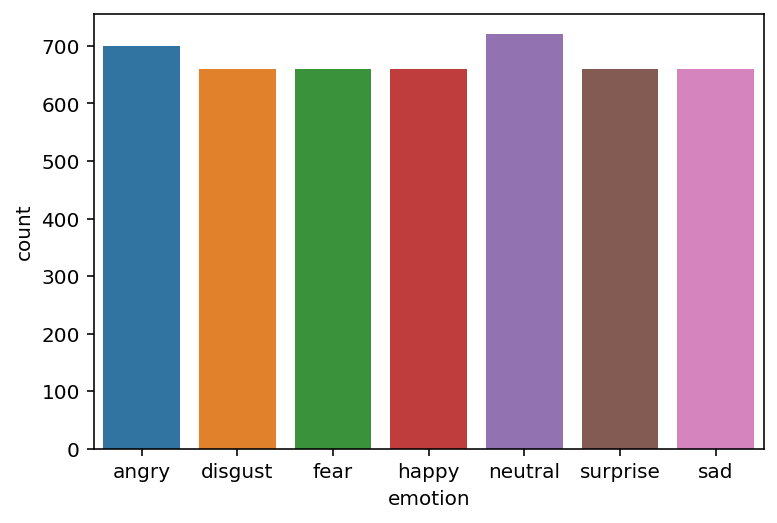

In [24]:
sns.countplot(x=df['emotion'])

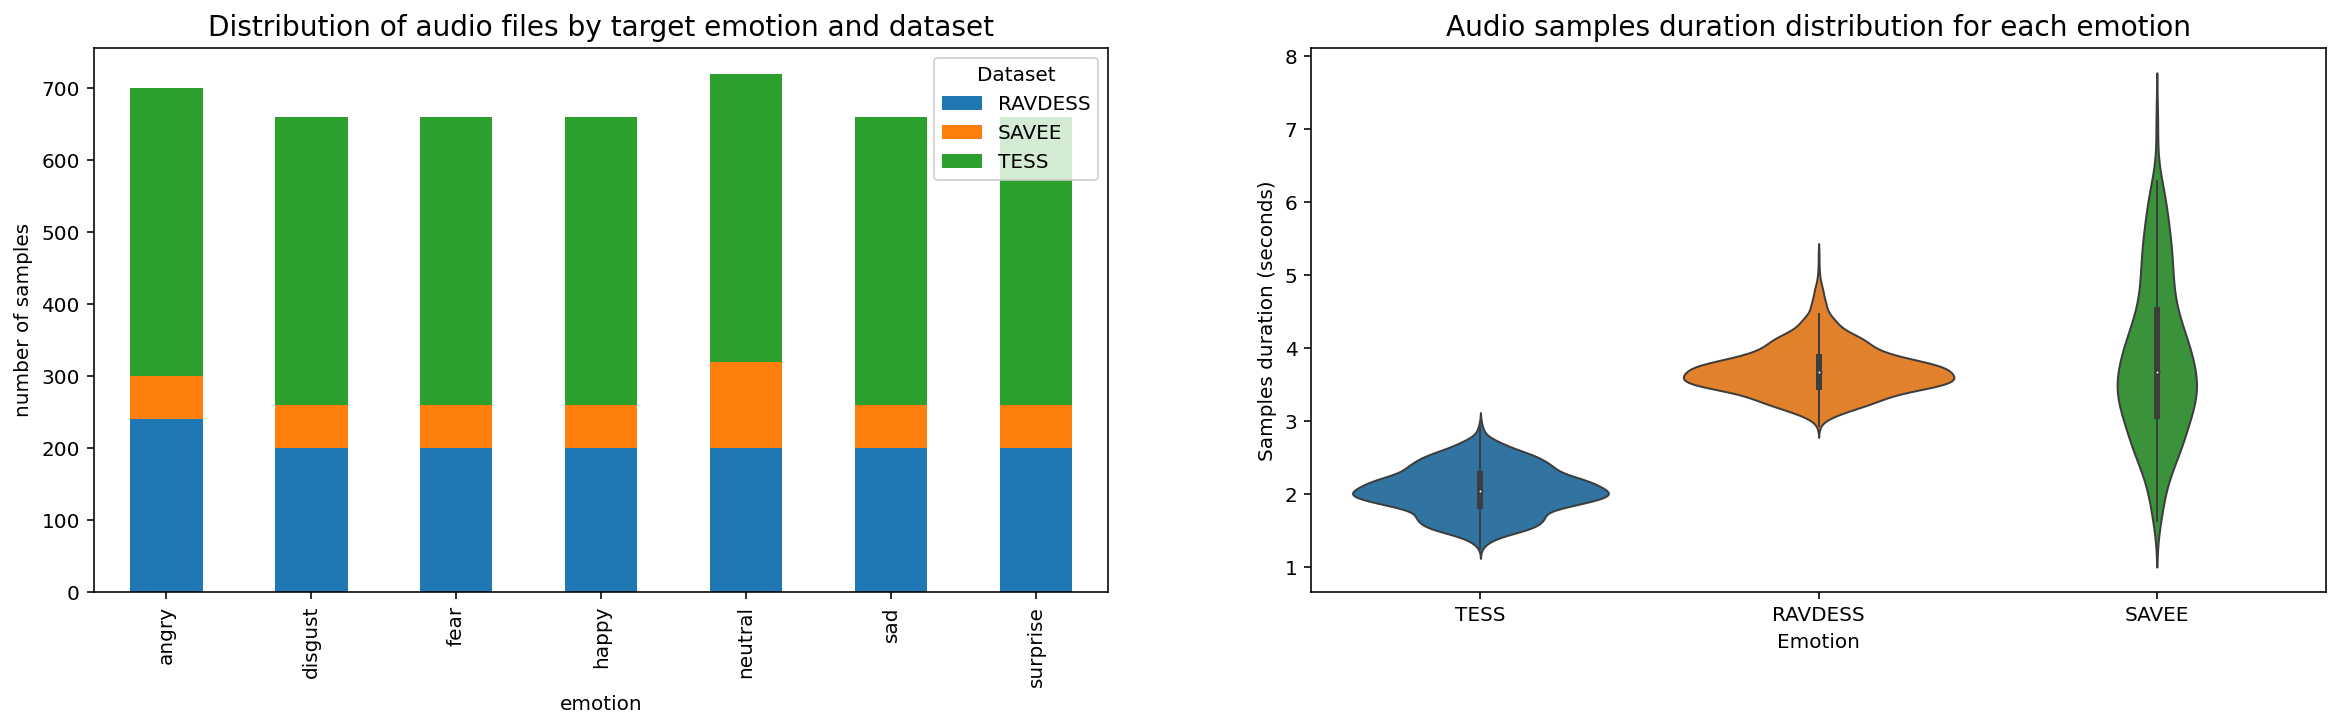

In [25]:
# Creating a figure with 2 subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))

# Check samples distribution
df.groupby(['emotion','dataset']).size().unstack().plot(kind='bar', stacked=True, ax=axes[0])
axes[0].set_title('Distribution of audio files by target emotion and dataset', size=14)
axes[0].set_ylabel('number of samples')
axes[0].legend(title='Dataset')

# Check duration distribution by each source using violin plots
sns.violinplot(x=df['dataset'],y=df['duration'], linewidth=1, ax=axes[1])
axes[1].set_xlabel('Emotion')
axes[1].set_ylabel('Samples duration (seconds)')
axes[1].set_title('Audio samples duration distribution for each emotion', size=14)

plt.show()

In [19]:
def show_audio(emotion):
    # create sublots
    fig, ax = plt.subplots(nrows=2,ncols=3, figsize=(20,8)) #ncols - количество графиков
    # filter dataframe to emotion)
    df_show = df.loc[df['emotion'] == emotion].reset_index(drop=True)
    index = random.randint(0, df_show.shape[0])
    # load audio file:
    y, sr = librosa.load(df_show.path[index], sr=16000)


    # Show spectral_bandwidth
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    S, phase = librosa.magphase(librosa.stft(y=y))
    times = librosa.times_like(spec_bw)
    centroid = librosa.feature.spectral_centroid(S=S)
    librosa.display.specshow(librosa.amplitude_to_db(S, ref=np.max),y_axis='log', x_axis='time', ax=ax[0,0])
    ax[0,0].set(title='log Power spectrogram: spectral_bandwidth')
    ax[0,0].fill_between(times, np.maximum(0, centroid[0] - spec_bw[0]),
                         np.minimum(centroid[0] + spec_bw[0], sr/2),
                         alpha=0.5, label='Centroid +- bandwidth')
    ax[0,0].plot(times, centroid[0], label='Spectral centroid', color='w')
    ax[0,0].legend(loc='lower right')

    
    hop_length = 512
    oenv = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
    tempogram = librosa.feature.fourier_tempogram(onset_envelope=oenv, sr=sr,
                                                  hop_length=hop_length)
    ac_tempogram = librosa.feature.tempogram(onset_envelope=oenv, sr=sr,
                                             hop_length=hop_length, norm=None)


    # Show 'Fourier tempogram'
    librosa.display.specshow(np.abs(tempogram), sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='fourier_tempo', cmap='magma',
                             ax=ax[0,1])
    ax[0,1].set(title='Fourier tempogram')
    ax[0,1].label_outer()


    librosa.display.specshow(ac_tempogram, sr=sr, hop_length=hop_length,
                             x_axis='time', y_axis='tempo', cmap='magma',
                             ax=ax[0,2])
    ax[0,2].set(title='Autocorrelation tempogram')



    # Extract 'n_mfcc' numbers of MFCCs components - in this case 30
    x_mfccs = librosa.feature.mfcc(y, sr=sr, n_mfcc=20)

    # Plot MFCCs
    librosa.display.specshow(x_mfccs, sr=sr, x_axis="time", norm=Normalize(vmin=-50, vmax=50), ax=ax[1,0])
    ax[1,0].set(title='MFCCs')


    y_ton = librosa.effects.harmonic(y)
    tonnetz = librosa.feature.tonnetz(y=y_ton, sr=sr)
    img_tonnetz = librosa.display.specshow(tonnetz, y_axis='tonnetz', x_axis='time', ax=ax[1,1])
    ax[1,1].set(title='Tonal Centroids (Tonnetz)')
    ax[1,1].label_outer()
    fig.colorbar(img_tonnetz, ax=ax[1,1])


    img_chroma = librosa.display.specshow(librosa.feature.chroma_cqt(y=y_ton, sr=sr),
                                          y_axis='chroma', x_axis='time', ax=ax[1,2])
    ax[1,2].set(title='Chroma')
    fig.colorbar(img_chroma, ax=ax[1,2])



    # Show metadata in title    
    plt.suptitle('File: {}  -  Emotion: {}'.format(df_show.path[index], df_show.emotion[index]), size=14)
    plt.tight_layout()
    plt.show()
    
    # Display media player for the selected file
    display(ipd.Audio(y, rate=sr))

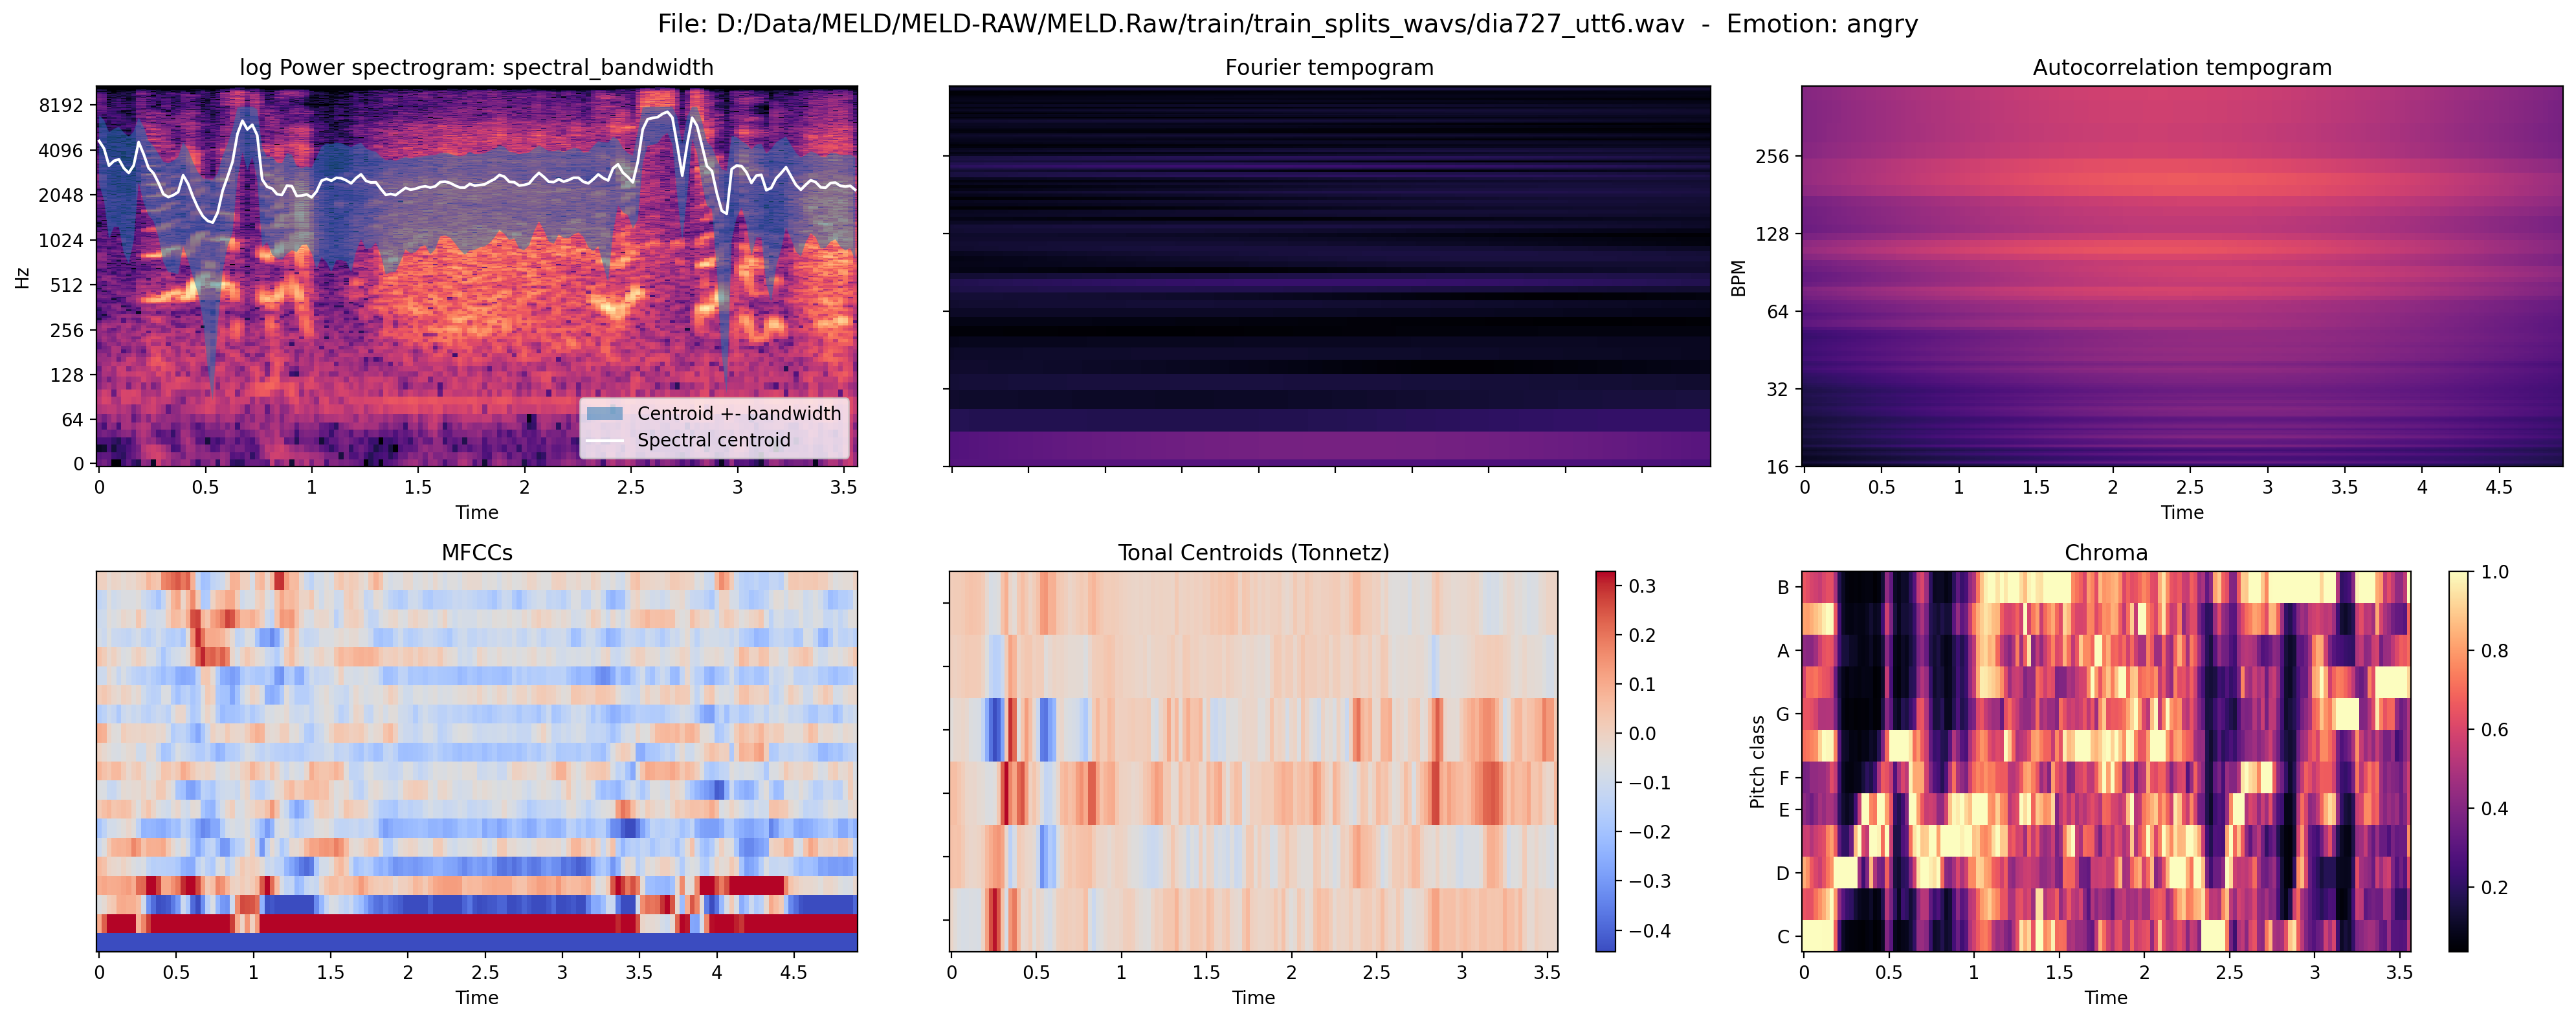

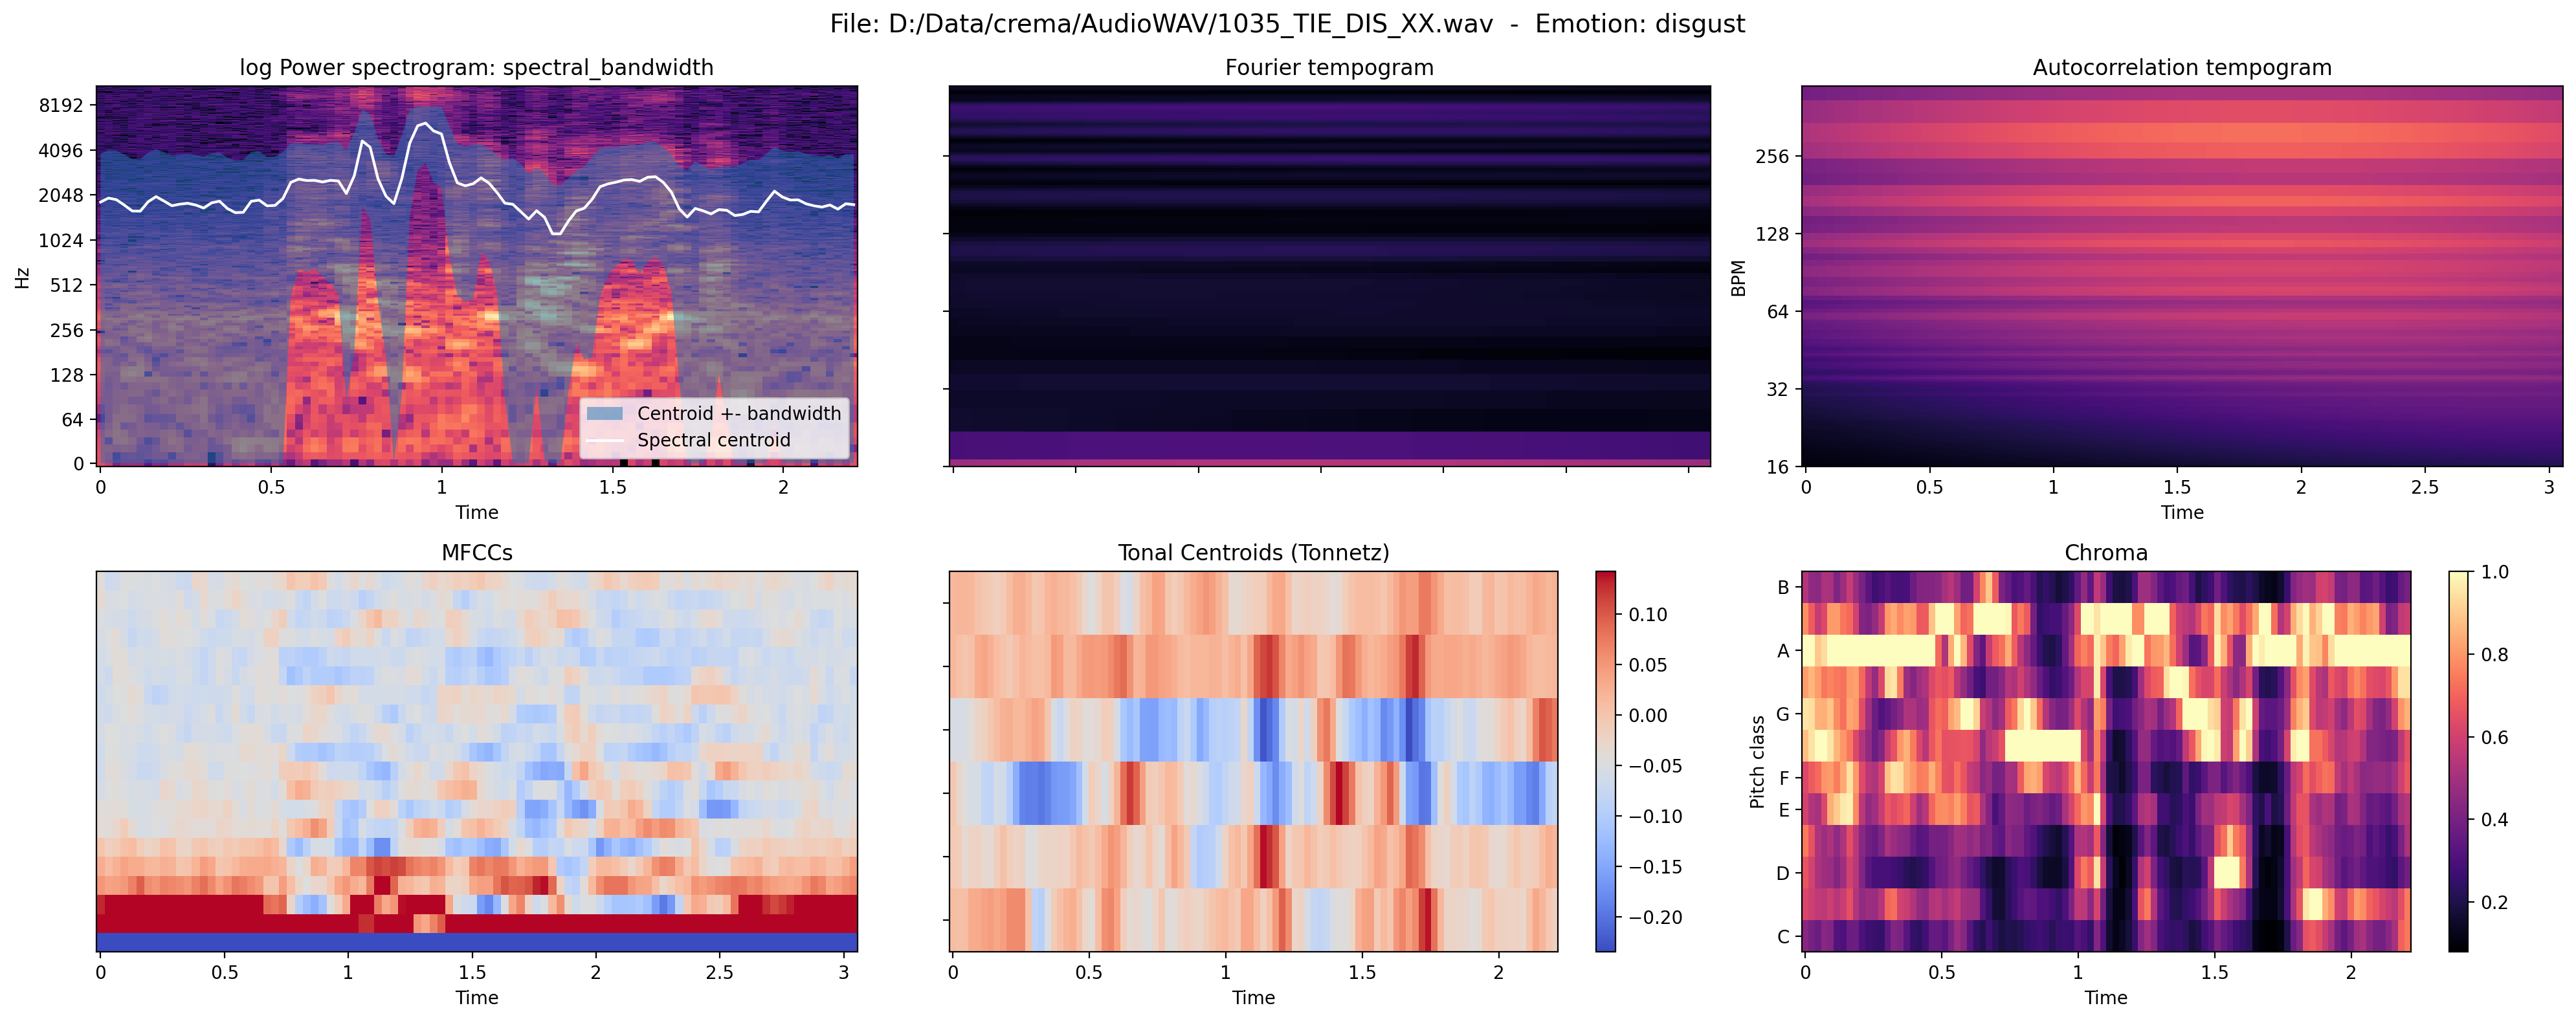

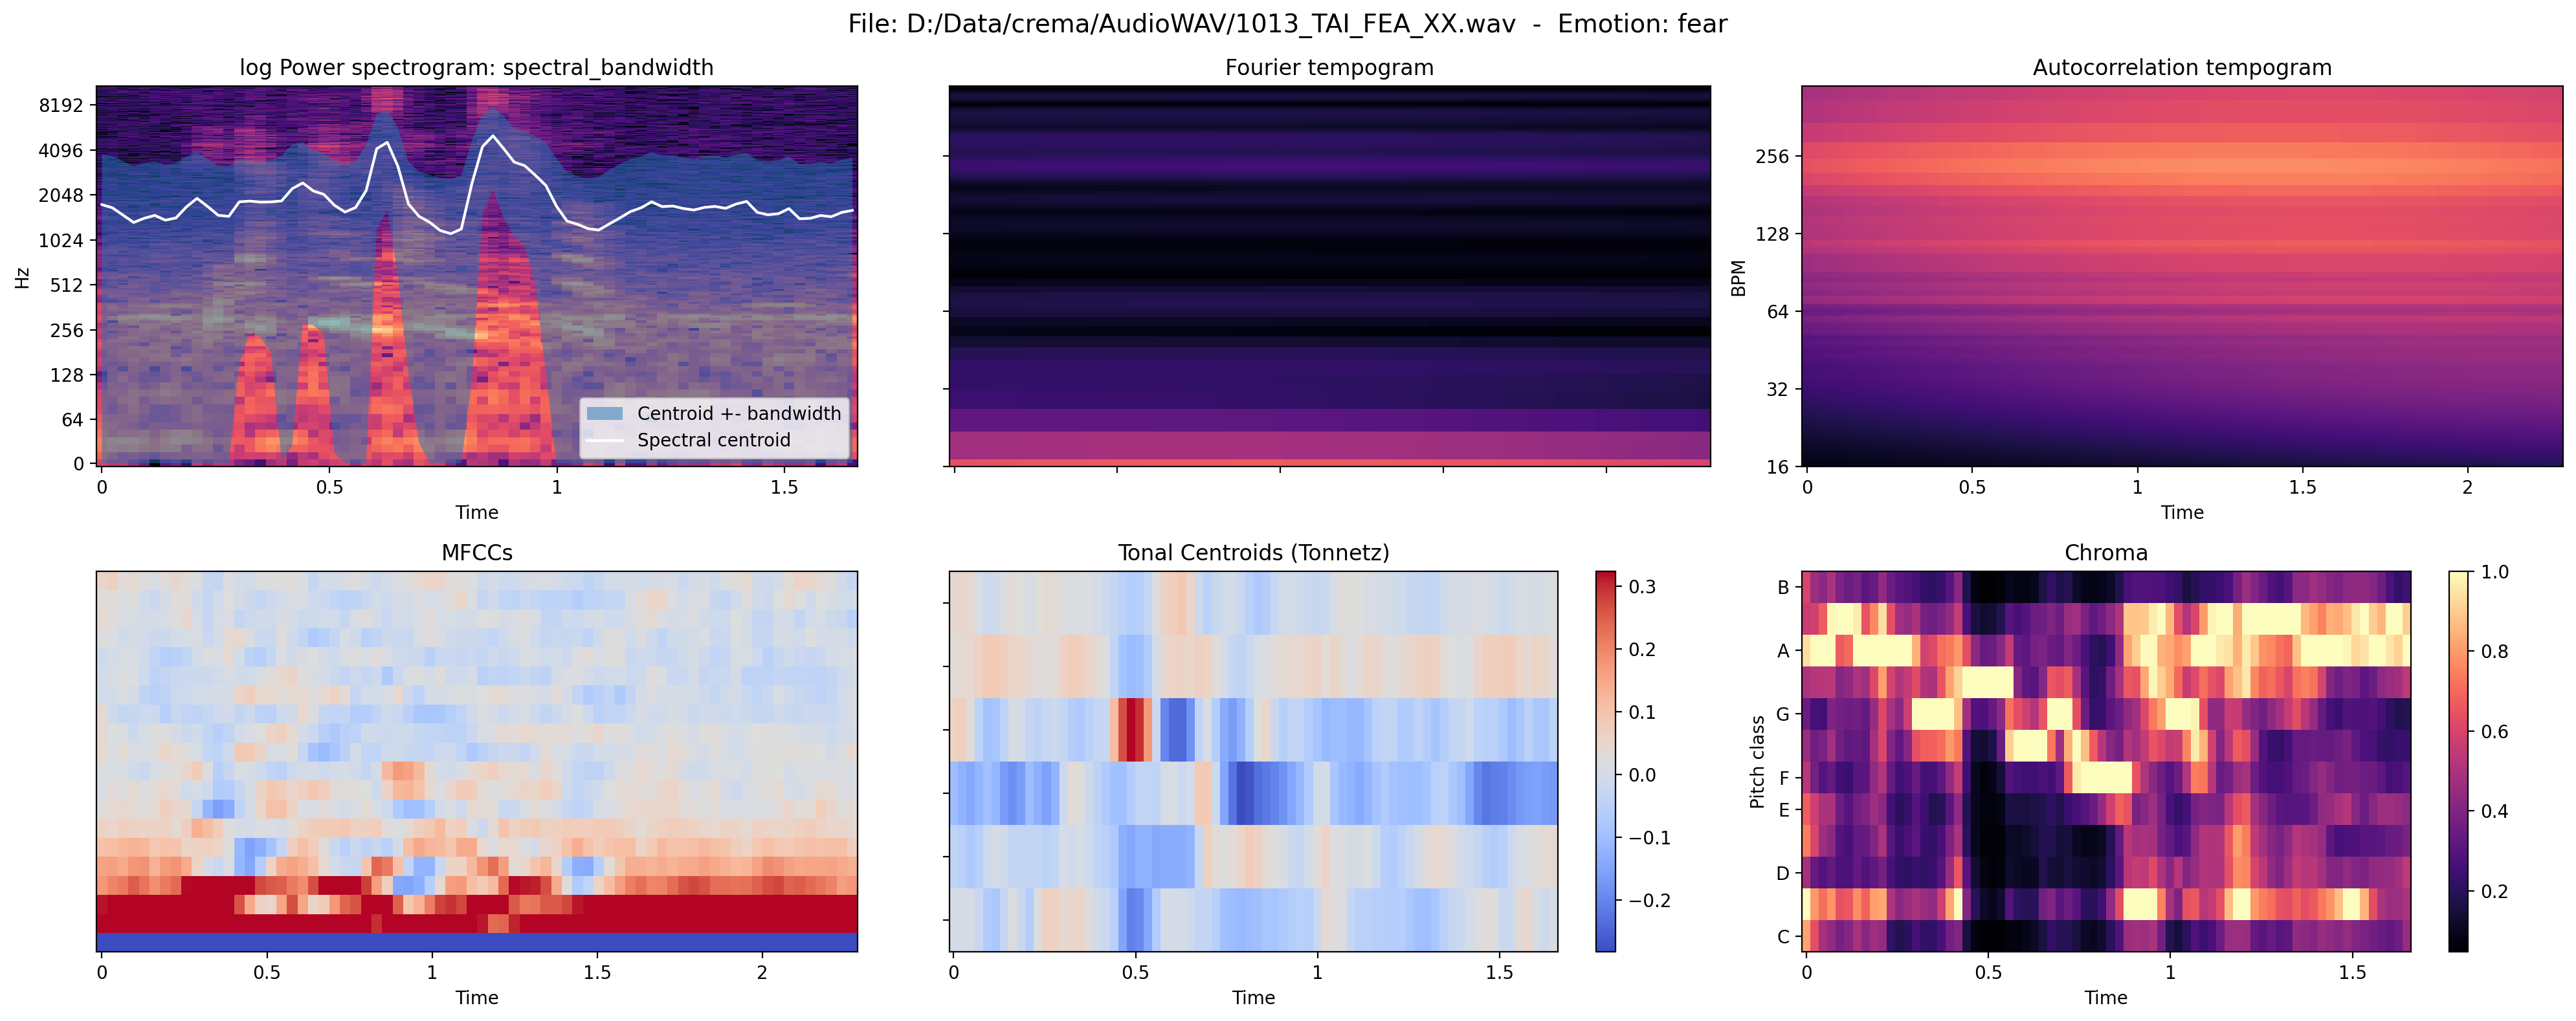

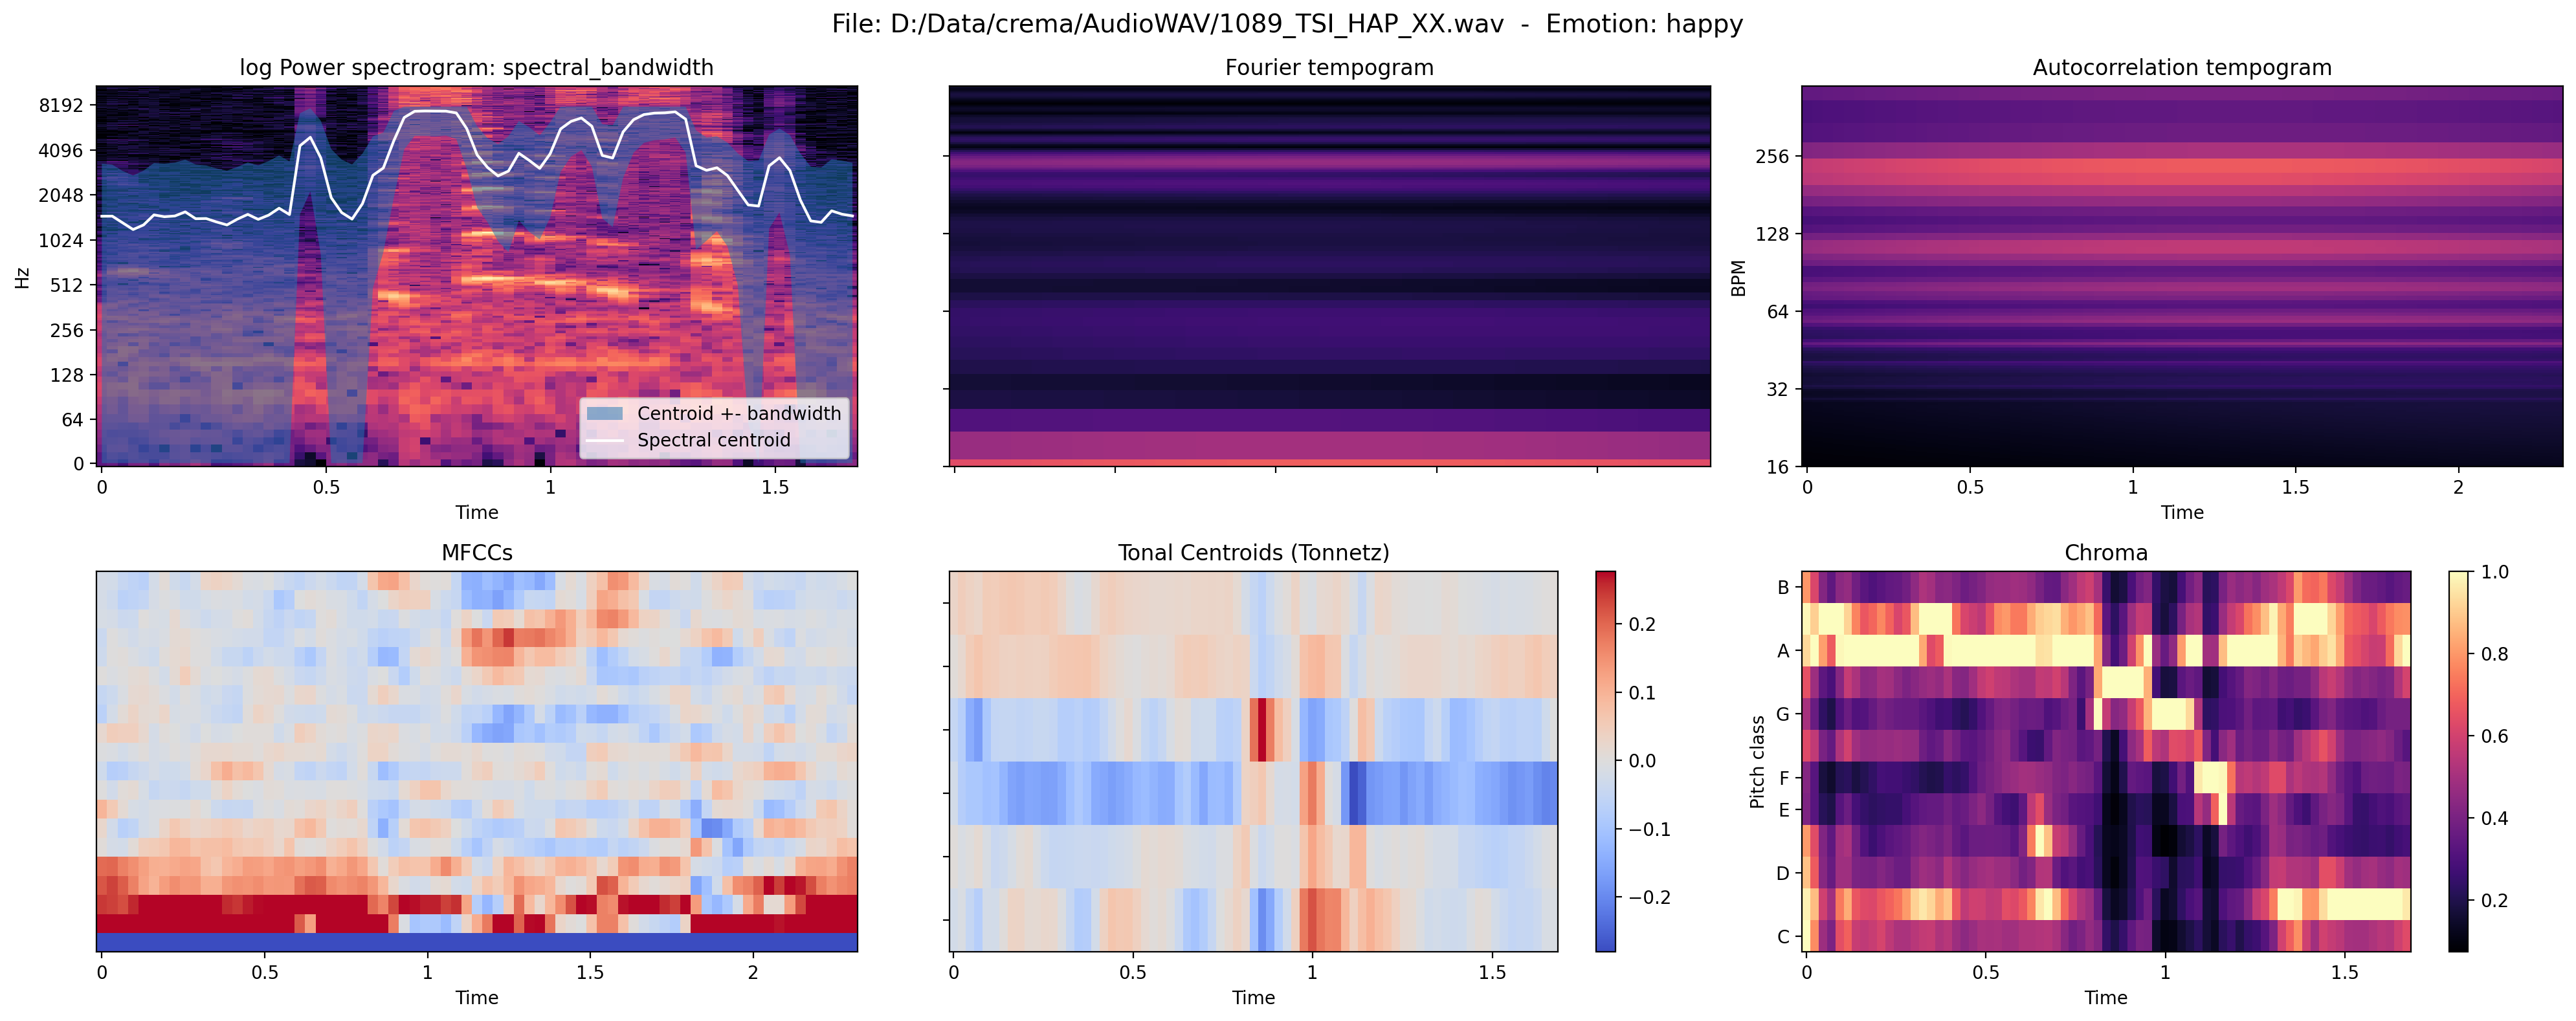

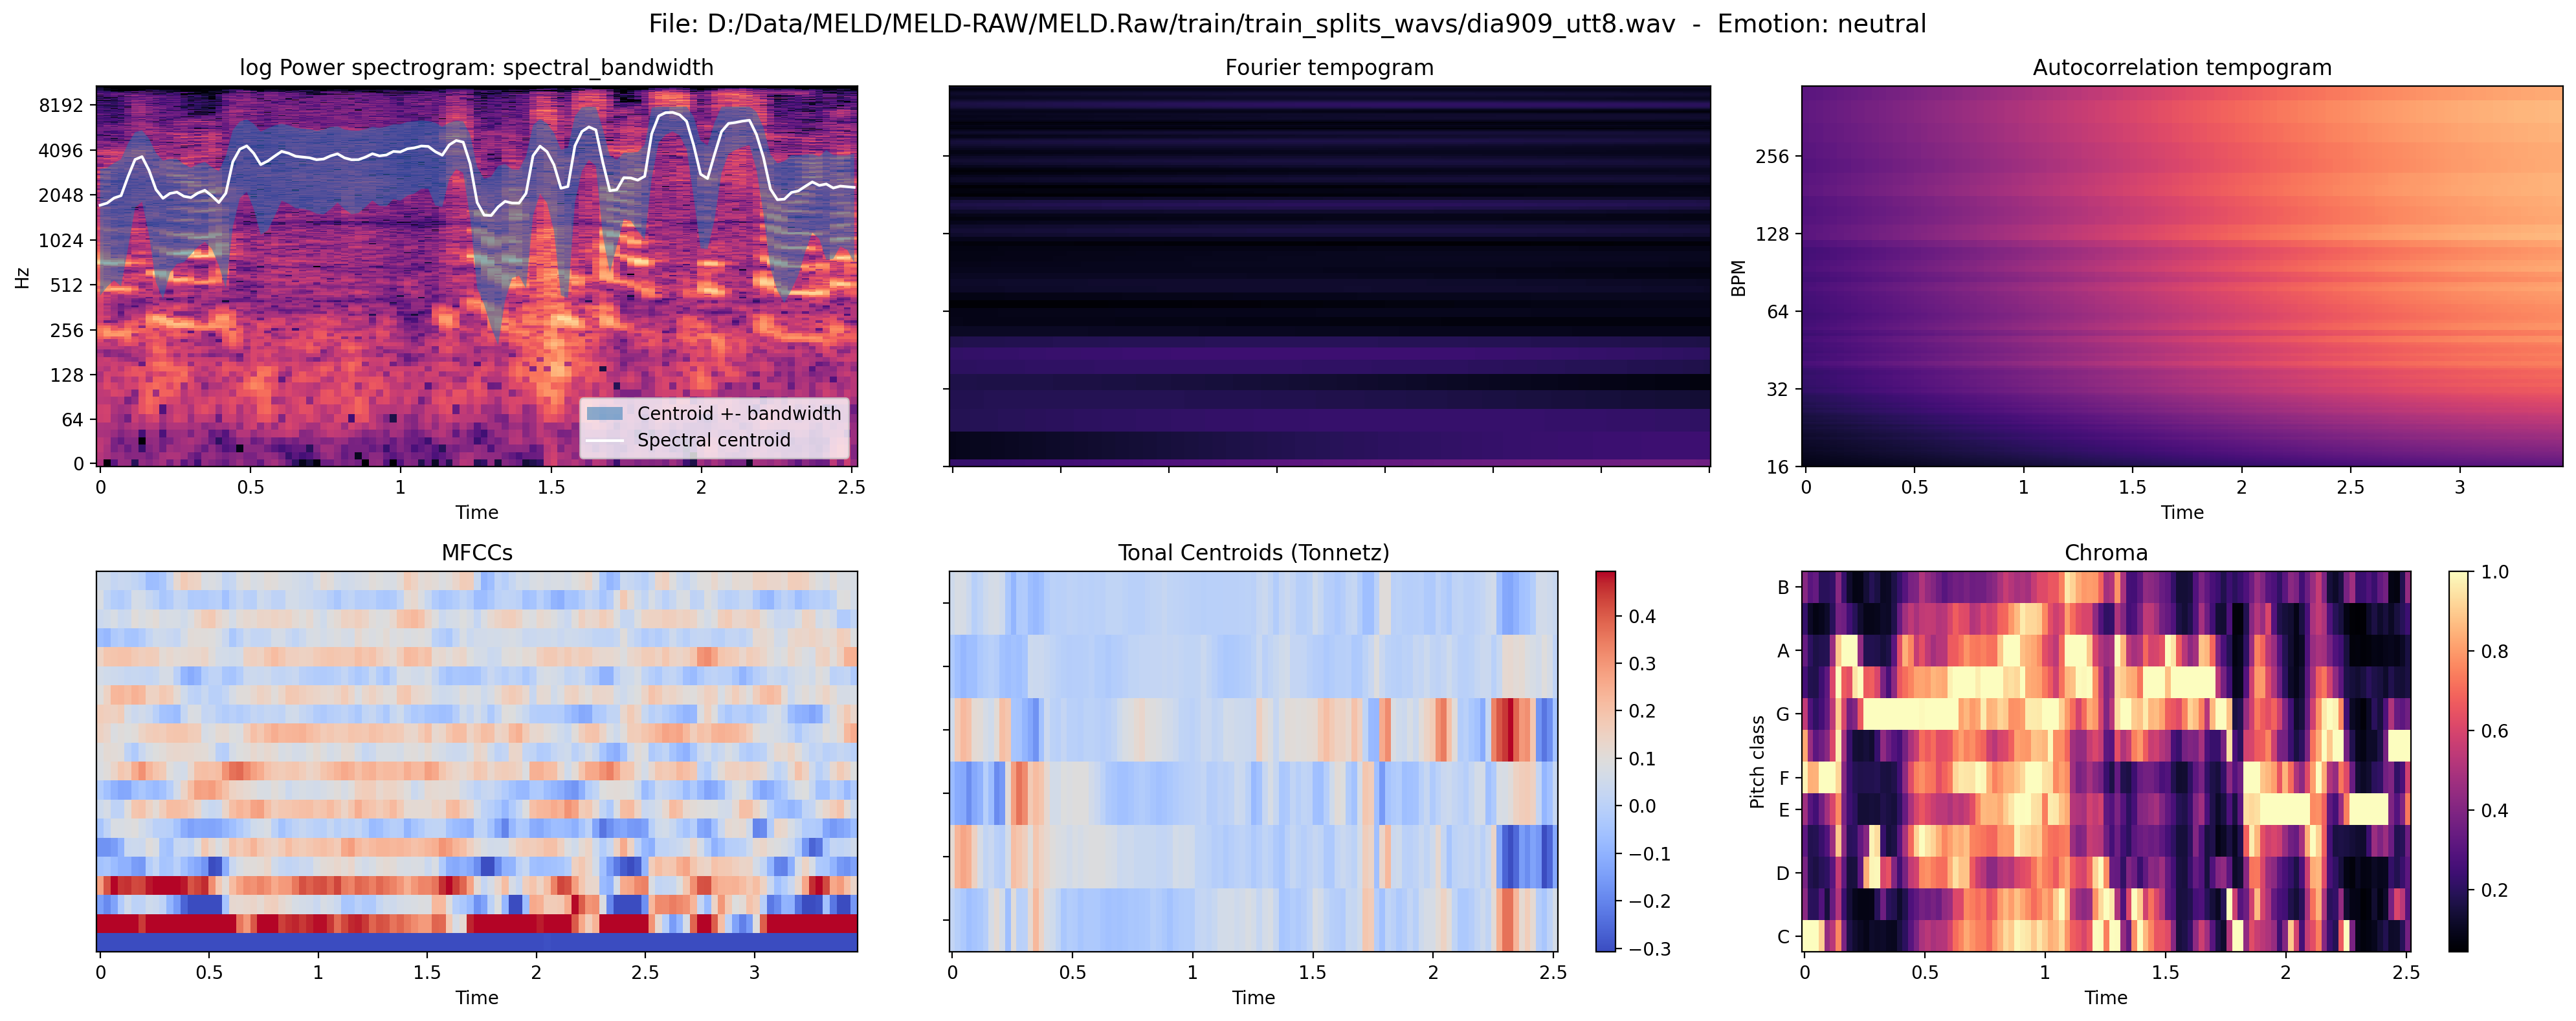

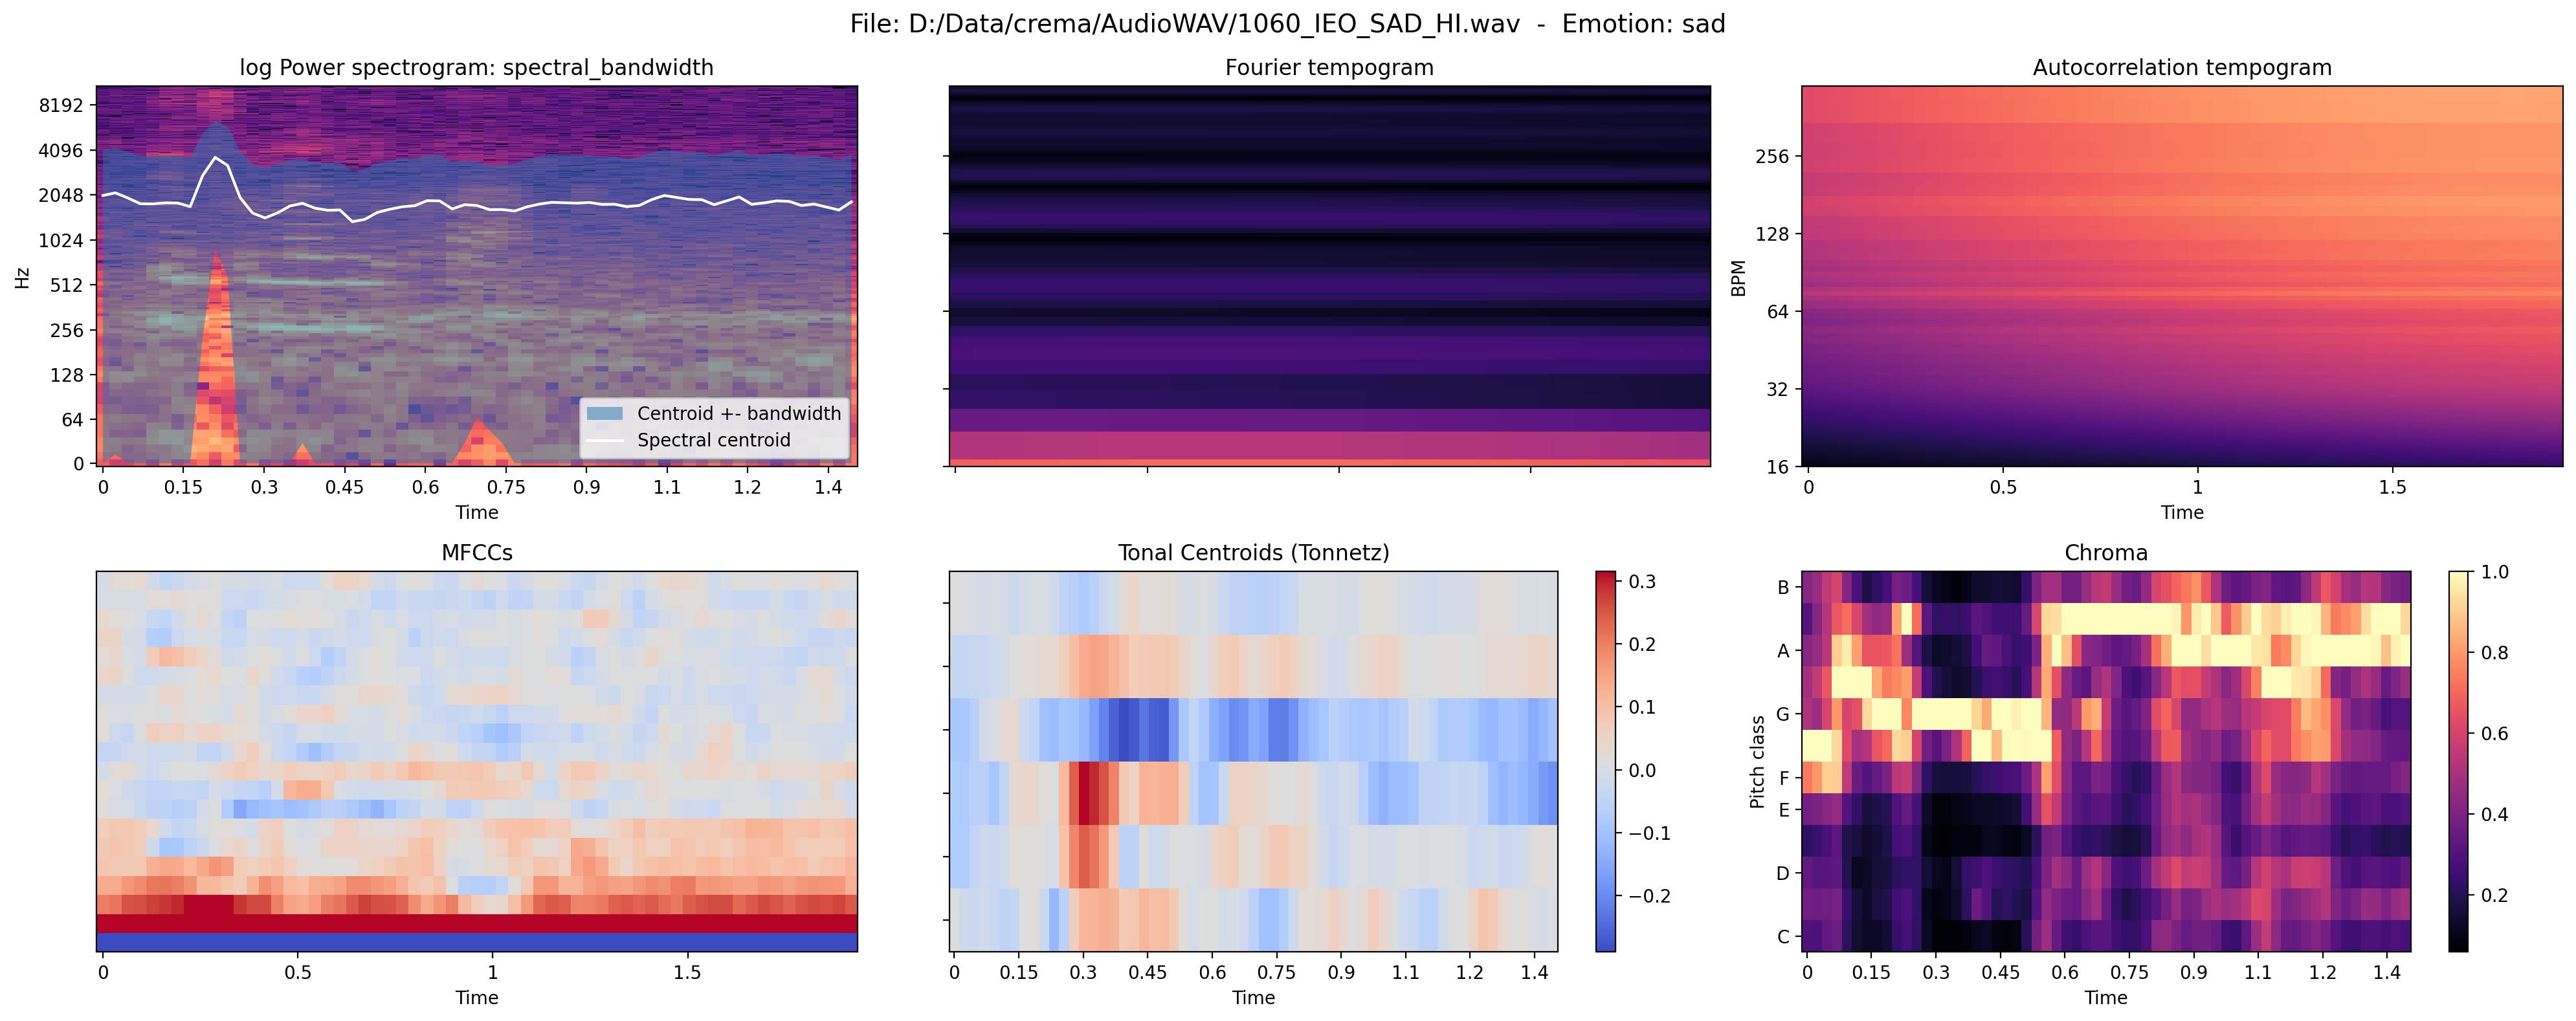

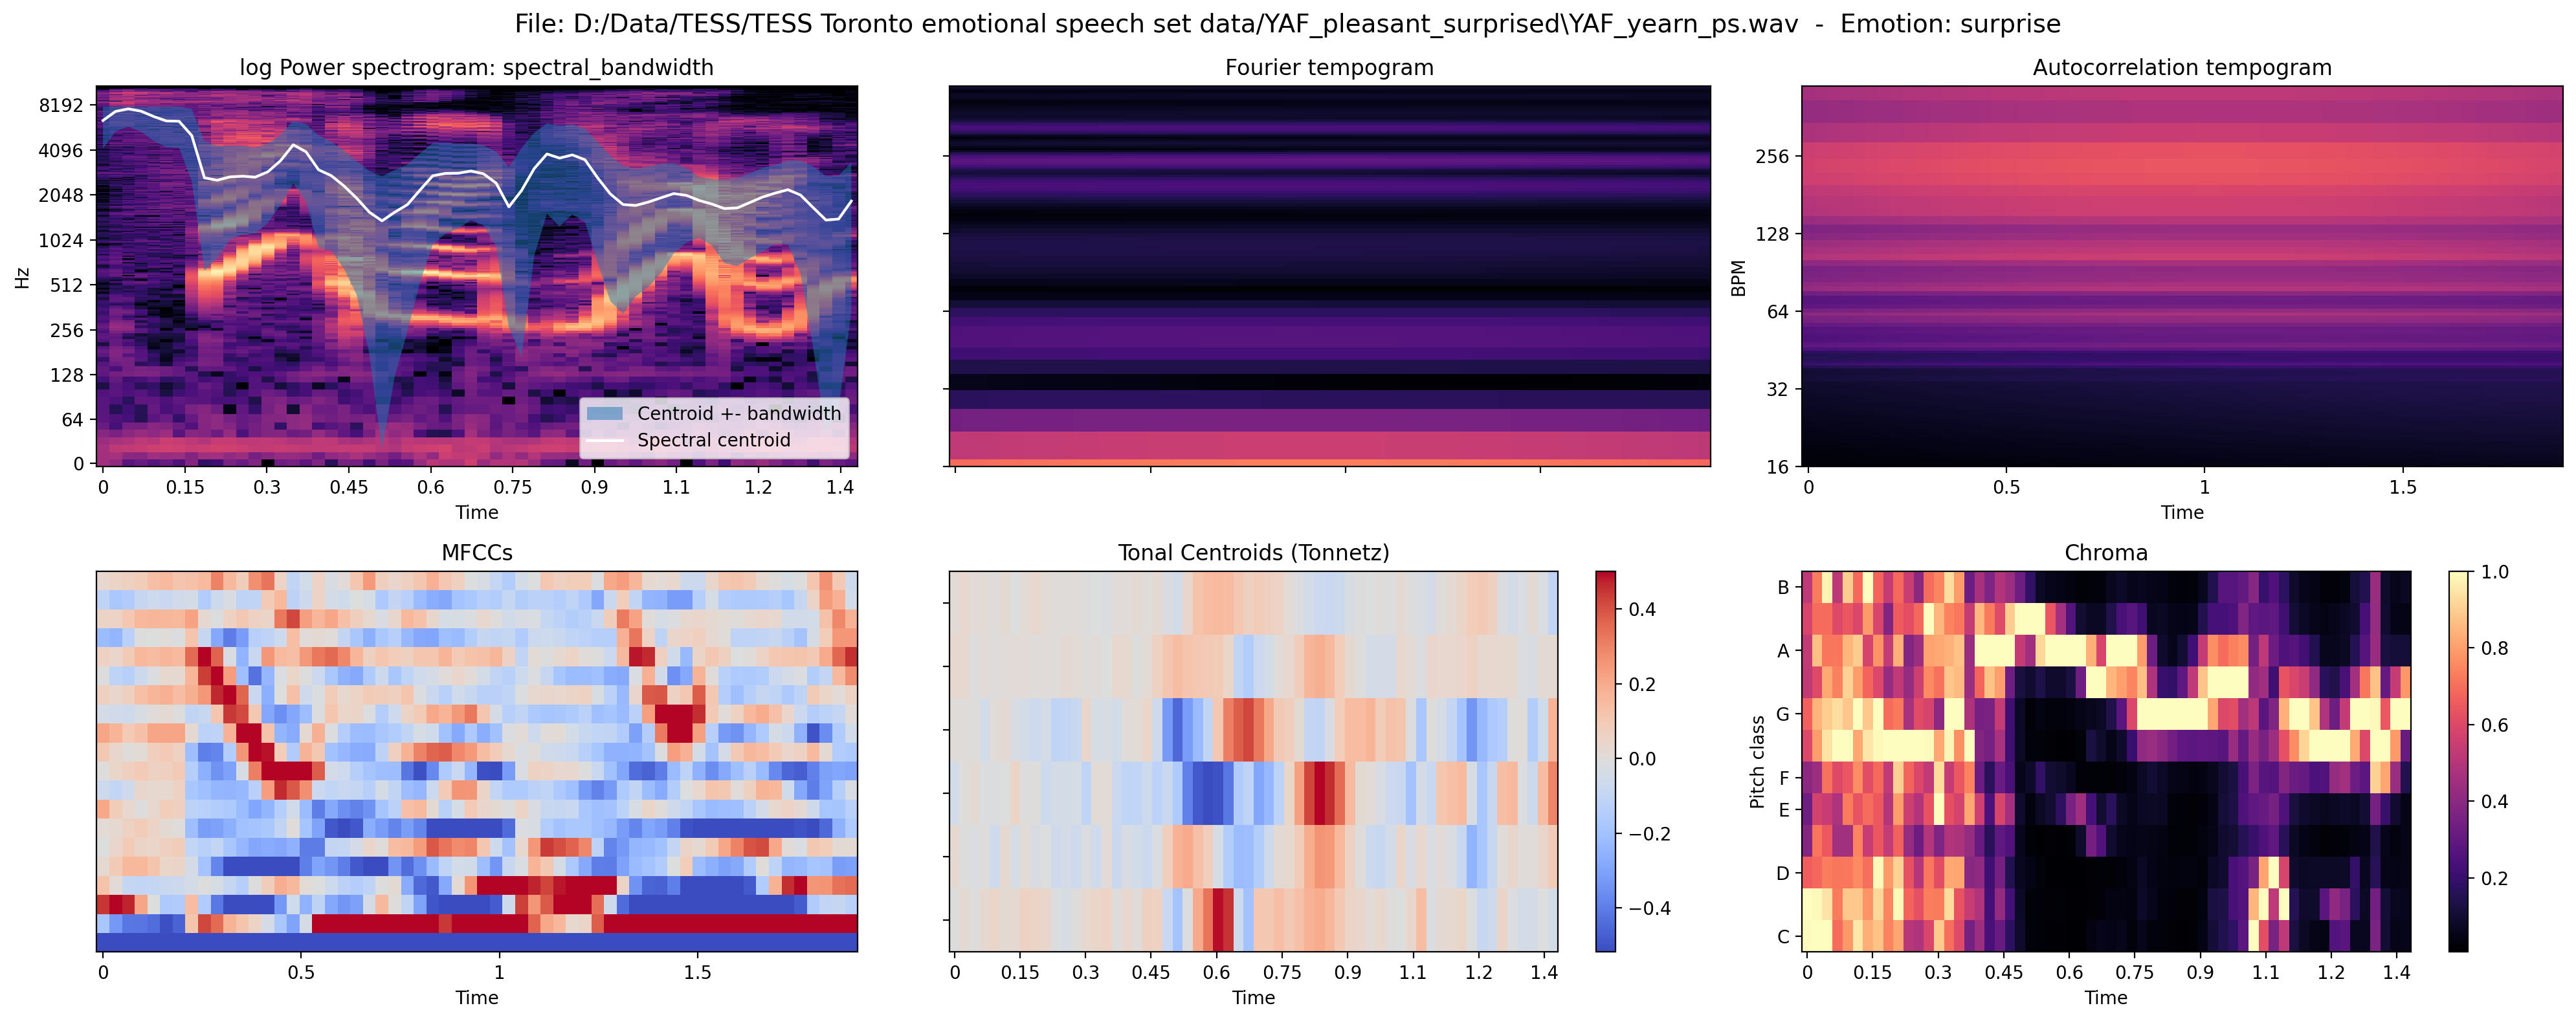

In [20]:
# Getting ordered list of emotions ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']
emotions = sorted(list(df.emotion.unique()))

# Get waveforms, spectograms, mfccs and media player for each emotion
for emotion in emotions:
    show_audio(emotion);

## 5. Извлечение из аудио значимых характеристик 

In [2]:
df = pd.read_csv('Files_for_program/df_all_tess_ravdess_savee.csv')

In [4]:
mean_mfcc_header, std_mfcc_header = '',''

header = 'path chroma_stft rms spec_cent_mean spec_cent_std spec_cent_skew spectral_bandwidth rolloff rolloff_std rolloff_skew zero_crossing_rate tonnetz log_power fourier tempogram'
for i in range(1, 14):
    mean_mfcc_header += f' mfcc{i}'
    std_mfcc_header += f' mfcc_std{i}'
header = header + mean_mfcc_header + std_mfcc_header + ' duration emotion dataset'
header = header.split()
file = open('Files_for_program/data_multiple_parameters_tess_ravdess_savee.csv', 'w', newline='')
with file:
    writer = csv.writer(file)
    writer.writerow(header)

for index, row in df.iterrows():
    y, sr = librosa.load(row.path)

    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr) 
    rms = librosa.feature.rms(y=y) 
    spec_cent = librosa.feature.spectral_centroid(y=y, sr=sr) 
    spec_bw = librosa.feature.spectral_bandwidth(y=y, sr=sr) 
    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr) 
    zcr = librosa.feature.zero_crossing_rate(y) 
    tonnetz = librosa.feature.tonnetz(y=y, sr=sr) 
    log_power = librosa.amplitude_to_db(np.abs(librosa.stft(y)), ref=np.max) 
    fourier = np.abs(librosa.stft(y))
    tempogram = librosa.feature.tempogram(y=y, sr=sr)
    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)

    to_append = f'{row.path},{np.mean(chroma_stft)},{np.mean(rms)},{np.mean(spec_cent)},{np.std(spec_cent)},{scipy.stats.skew(spec_cent,axis=1)[0]},{np.mean(spec_bw)},{np.mean(rolloff)},{np.std(rolloff)},{scipy.stats.skew(rolloff,axis=1)[0]},{np.mean(zcr)},{np.mean(tonnetz)},{np.mean(log_power)},{np.mean(fourier)},{np.mean(tempogram)}'
    mean_mfcc, std_mfcc = '',''
    for e in mfcc:
        mean_mfcc += f',{np.mean(e)}' 
        std_mfcc += f',{np.std(e)}'
    to_append = to_append + mean_mfcc + std_mfcc + f',{row.duration},{row.emotion},{row.dataset}'
    file = open('Files_for_program/data_multiple_parameters_tess_ravdess_savee.csv', 'a', newline='')
    with file:
        writer = csv.writer(file)
        writer.writerow(to_append.split(','))